In [1]:
#più canali

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
#name_data = '2018-11-27T10-29-42POP 2 BL .h5'
#name_data = '2018-11-27T12-03-02POP 2 stimulation.h5'
#name_data='2018-11-27T10-56-39MiP5 KA stimulation.h5'
#name_data='2018-11-27T11-24-28MiP3 stimulation.h5'
#name_data='2018-11-27T10-40-53POP 3 BL .h5'
#name_data='2019-01-23T11-05-52MIP3 health cortical .h5'
#name_data='2019-01-23T15-49-43MEA2 healthy cortical .h5'
#name_data='2019-01-23T16-22-47Pop3 healthy cortical .h5'
name_data='2019-01-23T16-06-32Pop1 healthy cortical .h5'

complete_string='/Users/Gaia_1/Desktop/h5files/'+name_data

In [3]:
data = h5py.File(complete_string,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4260000, 60)


In [4]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova=readings.iloc[inizio:len_data, 10:17]
prova=prova.drop([b'Ref'],axis=1)
ref=readings[b'Ref']
ref=ref[inizio:len_data]

print(prova.shape,ref.shape)

(4260000, 6) (4260000,)


In [5]:
prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
prova=filt_prova
prova.shape

  0%|          | 0/6 [00:00<?, ?it/s]

(4260000, 6)

# Spike detection

In [6]:
pos_ind=[]
neg_ind=[]
for electrode in tqdm(prova.columns):
    channel=prova[electrode]
    pos, neg=find_all_spikes(channel)
    pos_ind.append(pos)
    neg_ind.append(neg)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 7126 negative spikes 7682 detected spikes: 14808 firing rate:  34.76056338028169


  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 7023 negative spikes 7542 detected spikes: 14565 firing rate:  34.190140845070424


  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 6996 negative spikes 7291 detected spikes: 14287 firing rate:  33.53755868544601


  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 7089 negative spikes 7620 detected spikes: 14709 firing rate:  34.528169014084504


  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 8604 negative spikes 6725 detected spikes: 15329 firing rate:  35.98356807511737


  0%|          | 0/4250000 [00:00<?, ?it/s]

positive spikes 7115 negative spikes 7645 detected spikes: 14760 firing rate:  34.647887323943664


BL: window 3000 (threshold 4 MAD) firing 18    
BL: window 300 (thresh 3), firing 89    
KA: window 3000 (thresh 3), firing 94    
KA: window 3000 (thresh 4), firing 29    
KA: window 300, (thresh 4) firing 39   
KA: window 300, (thresh 3) firing 108   

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
#segnale KA stimulation: firing rate=8 (spikes 5054)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [7]:
pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]

for i,electrode in enumerate(tqdm(prova.columns)):
    pos=pos_ind[i]
    neg=neg_ind[i]
    channel=prova[electrode]
    pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
    pos_cut.append(pos_cut1)
    neg_cut.append(neg_cut1)
    n_pos.append(n_pos1)
    n_neg.append(n_neg1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
for i in (tqdm(range(len(pos_cut)))):
    pos_cut[i]=mask_cuts(pos_cut[i])
    neg_cut[i]= mask_cuts(neg_cut[i])

  0%|          | 0/6 [00:00<?, ?it/s]

x=randint(1,len(pos_cut)-1)
y=randint(1,len(pos_cut[x])-1)

plt.plot(savedp[x][y])
plt.plot(pos_cut[x][y])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters= hdbscan_clustering(pos_cut[channel],n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)

BL (window 3000, thresh 4) (less function) fuzzy (1.8, 4, 3.99)   
BL (window 300) (less function) fuzzy (19, 18, 9)   
BL (window 300) (less function) dbscan (30, 9)   
BL (window 300) (bit less function std) fuzzy (8.9, 18.2, 17.8)   
BL (window 300) (more cut function) fuzzy (8.9, 17.7, 18.3)   
BL (window 300) (more cut function) dbscan (29, 6)   
BL (less cut function) fuzzy: (15, 8 ,15)   

KA (window 300, thresh 4) (less function) fuzzy (3.8, 4, 1.9)   
KA (window 3000, thresh 4) (less function) fuzzy (2.6, 1.2, 2.8)   
KA stimualtion 3 clusters fuzzy: (13, 6, 12)   
KA stim (window 300) (new cut function) (1.17,2.55,2.37)   


final_data_neg=[]
for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters= hdbscan_clustering(neg_cut[channel],n_neg[channel],data)
    final_data_neg.append(channel_clusters)

In [9]:
# togliere dal best score il DB score e usare solo il silhouette score ma su 15 prove
# fare scrematura una volta formati i clusters, togliendo gli spike con distanza DTW sopra soglia
# provare anche DTW tra medie di cluster

  0%|          | 0/6 [00:00<?, ?it/s]

Total spikes:  7126
For 2 clusters, the silhouette score is: 0.114
For 3 clusters, the silhouette score is: 0.127
For 4 clusters, the silhouette score is: 0.129
For 5 clusters, the silhouette score is: 0.137
For 6 clusters, the silhouette score is: 0.133
For 7 clusters, the silhouette score is: 0.139
For 8 clusters, the silhouette score is: 0.141
For 9 clusters, the silhouette score is: 0.147
For 10 clusters, the silhouette score is: 0.126
For 11 clusters, the silhouette score is: 0.136
For 12 clusters, the silhouette score is: 0.138
For 13 clusters, the silhouette score is: 0.135
For 14 clusters, the silhouette score is: 0.133


Best cluster in the range 2 to  14 :  9 , with a silhouette score of:  0.14710452134066263   


firing rate threshold:  1.2888720150879551


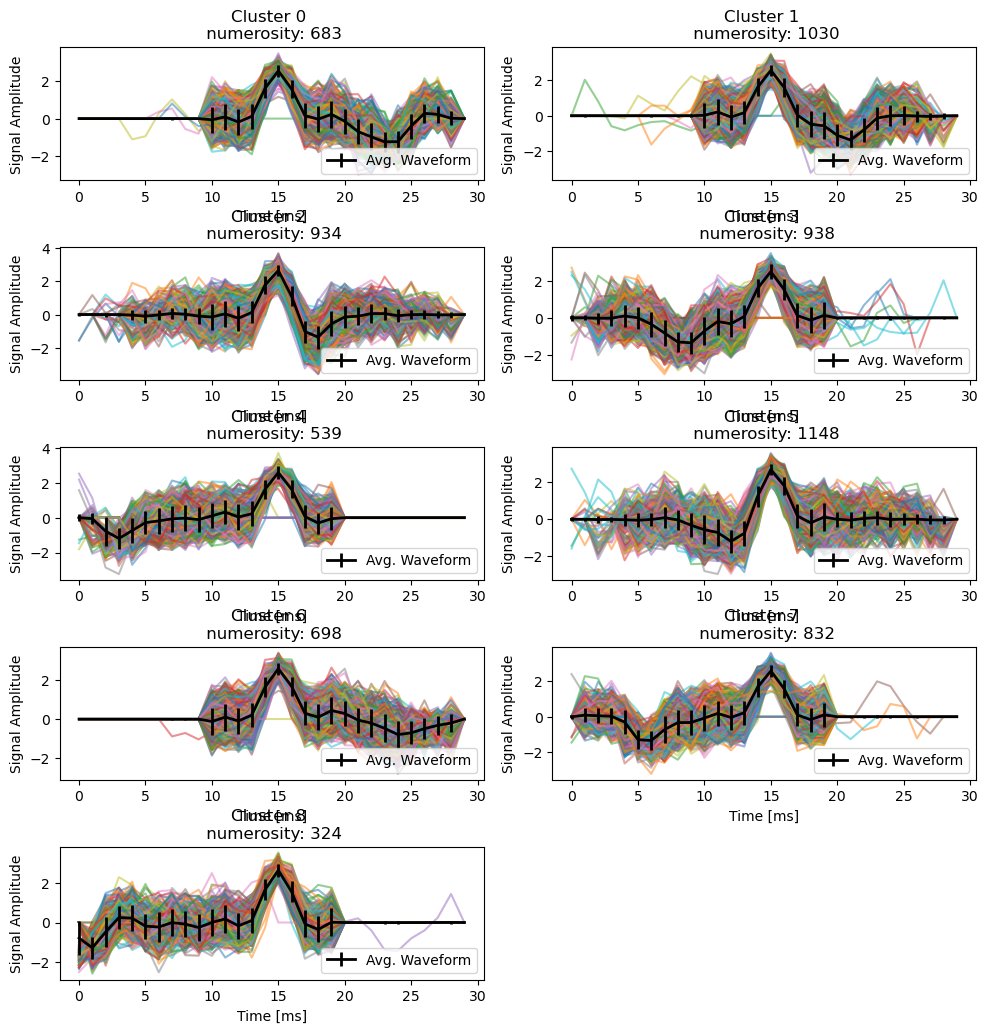

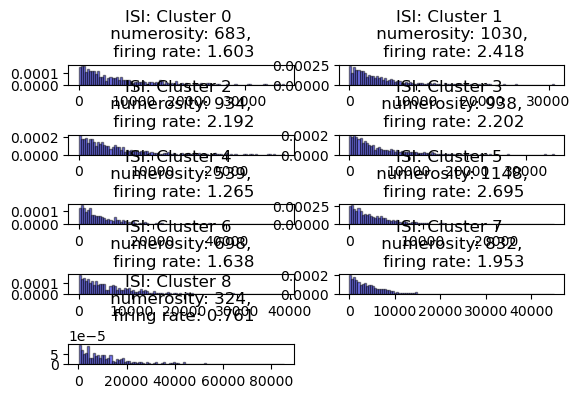

Total spikes:  7023
For 2 clusters, the silhouette score is: 0.109
For 3 clusters, the silhouette score is: 0.129
For 4 clusters, the silhouette score is: 0.126
For 5 clusters, the silhouette score is: 0.138
For 6 clusters, the silhouette score is: 0.132
For 7 clusters, the silhouette score is: 0.144
For 8 clusters, the silhouette score is: 0.149
For 9 clusters, the silhouette score is: 0.149
For 10 clusters, the silhouette score is: 0.141
For 11 clusters, the silhouette score is: 0.133
For 12 clusters, the silhouette score is: 0.131
For 13 clusters, the silhouette score is: 0.134
For 14 clusters, the silhouette score is: 0.129


Best cluster in the range 2 to  14 :  9 , with a silhouette score of:  0.14914481742013105   


firing rate threshold:  1.2144961808126717


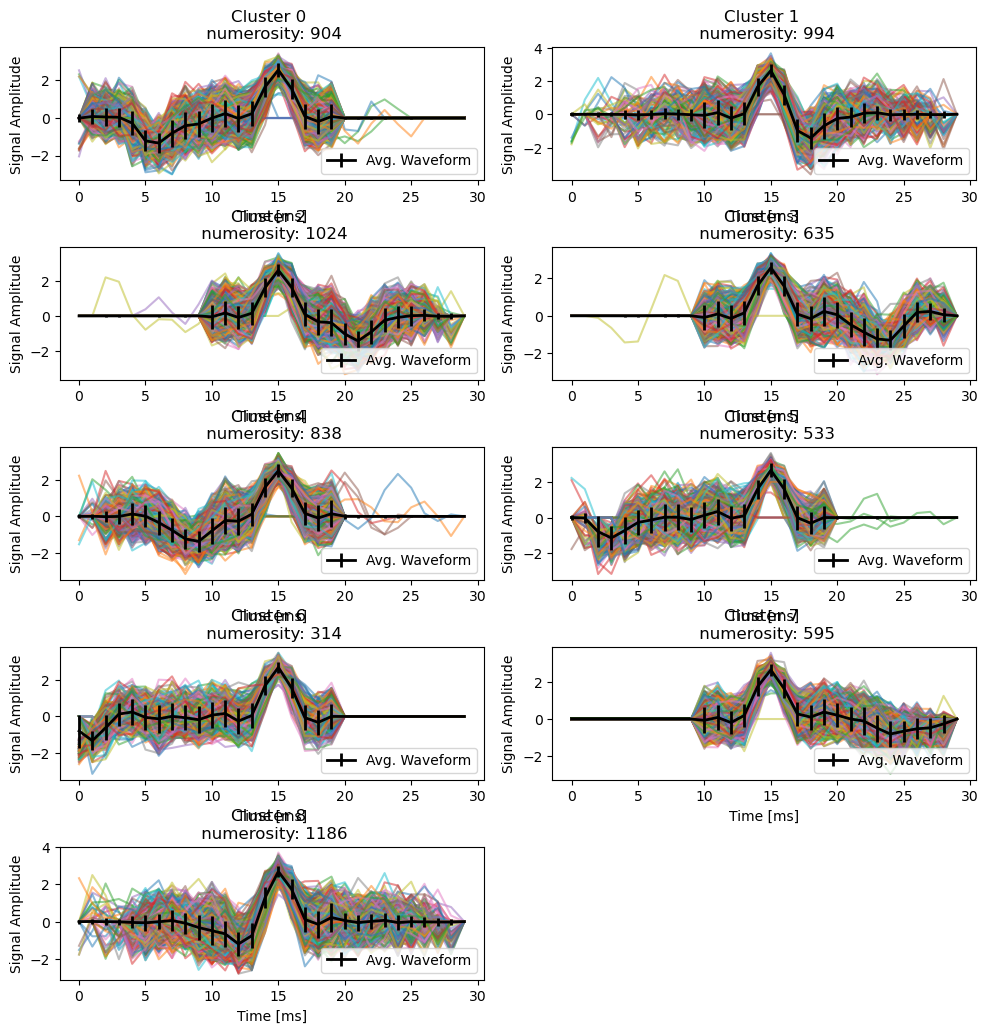

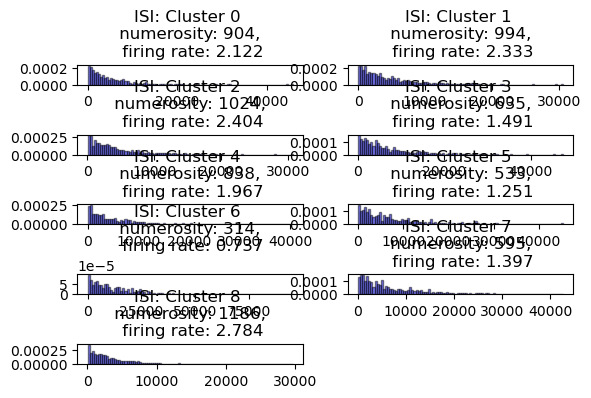

Total spikes:  6996
For 2 clusters, the silhouette score is: 0.111
For 3 clusters, the silhouette score is: 0.125
For 4 clusters, the silhouette score is: 0.126
For 5 clusters, the silhouette score is: 0.130
For 6 clusters, the silhouette score is: 0.137
For 7 clusters, the silhouette score is: 0.139
For 8 clusters, the silhouette score is: 0.143
For 9 clusters, the silhouette score is: 0.152
For 10 clusters, the silhouette score is: 0.142
For 11 clusters, the silhouette score is: 0.137
For 12 clusters, the silhouette score is: 0.127
For 13 clusters, the silhouette score is: 0.128
For 14 clusters, the silhouette score is: 0.128


Best cluster in the range 2 to  14 :  9 , with a silhouette score of:  0.15169496168561317   


firing rate threshold:  1.3035535555677762


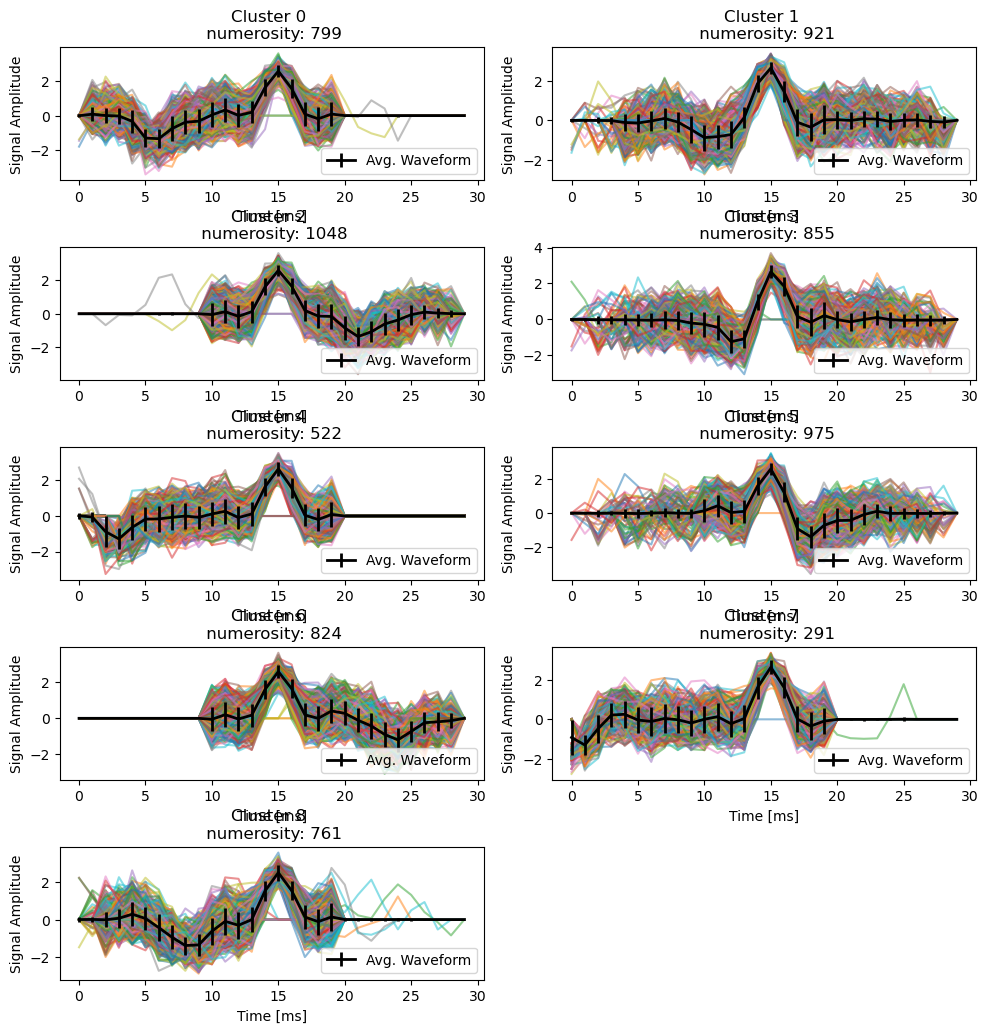

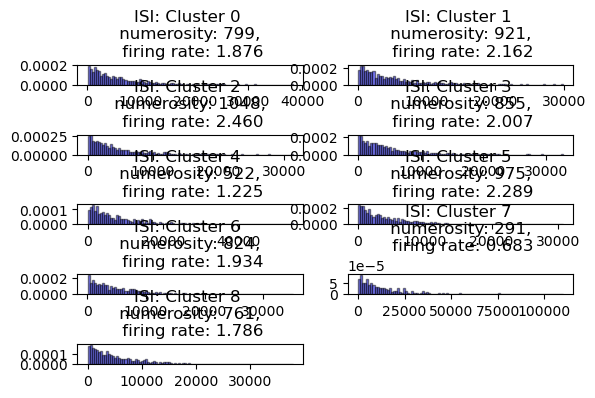

Total spikes:  7089
For 2 clusters, the silhouette score is: 0.107
For 3 clusters, the silhouette score is: 0.119
For 4 clusters, the silhouette score is: 0.126
For 5 clusters, the silhouette score is: 0.129
For 6 clusters, the silhouette score is: 0.128
For 7 clusters, the silhouette score is: 0.136
For 8 clusters, the silhouette score is: 0.144
For 9 clusters, the silhouette score is: 0.147
For 10 clusters, the silhouette score is: 0.140
For 11 clusters, the silhouette score is: 0.136
For 12 clusters, the silhouette score is: 0.132
For 13 clusters, the silhouette score is: 0.128
For 14 clusters, the silhouette score is: 0.126


Best cluster in the range 2 to  14 :  9 , with a silhouette score of:  0.1473852005772109   


firing rate threshold:  1.1865542073776751


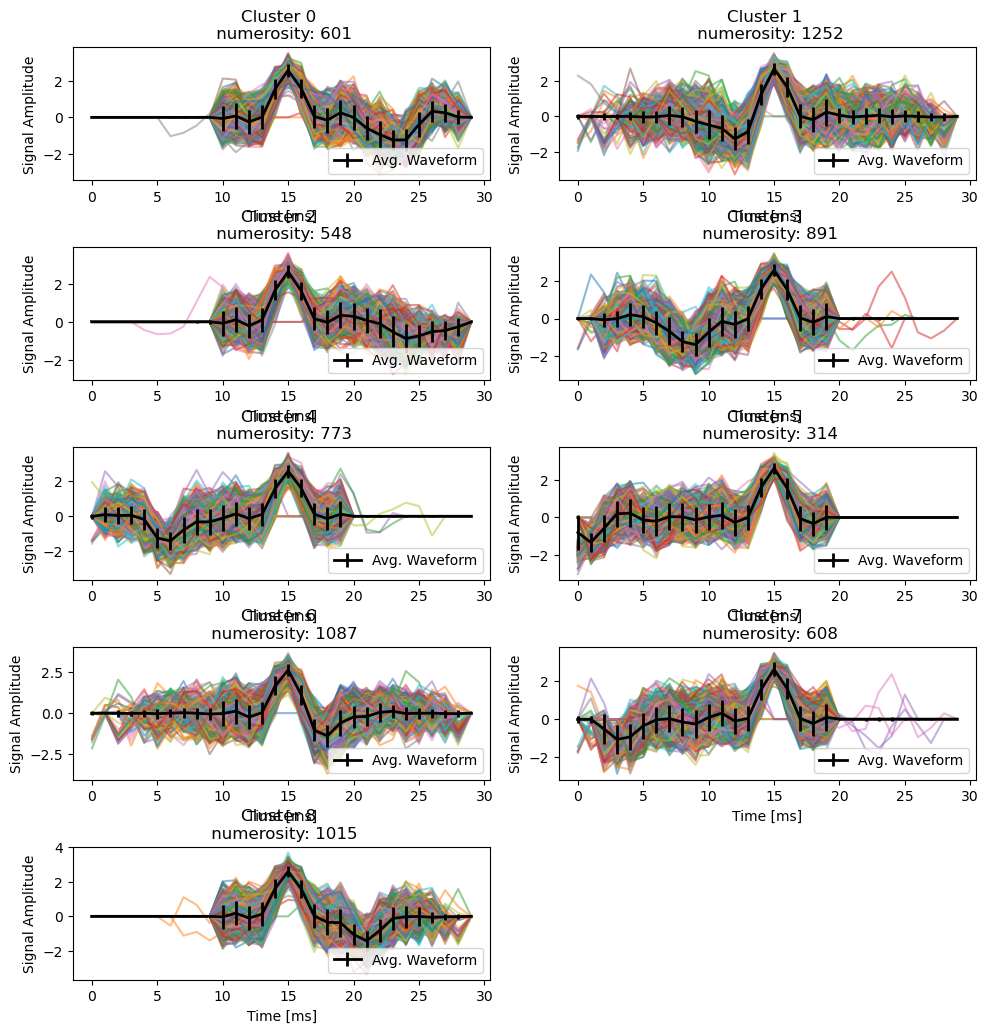

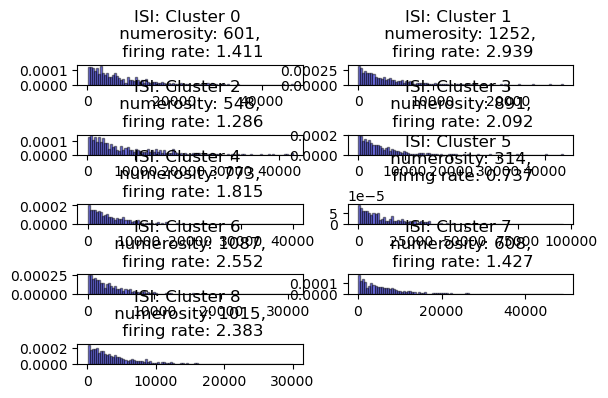

Total spikes:  8604
For 2 clusters, the silhouette score is: 0.124
For 3 clusters, the silhouette score is: 0.134
For 4 clusters, the silhouette score is: 0.137
For 5 clusters, the silhouette score is: 0.146
For 6 clusters, the silhouette score is: 0.141
For 7 clusters, the silhouette score is: 0.138
For 8 clusters, the silhouette score is: 0.139
For 9 clusters, the silhouette score is: 0.143
For 10 clusters, the silhouette score is: 0.136
For 11 clusters, the silhouette score is: 0.128
For 12 clusters, the silhouette score is: 0.135
For 13 clusters, the silhouette score is: 0.130
For 14 clusters, the silhouette score is: 0.125


Best cluster in the range 2 to  14 :  5 , with a silhouette score of:  0.14648938621804458   


firing rate threshold:  2.585771591842571


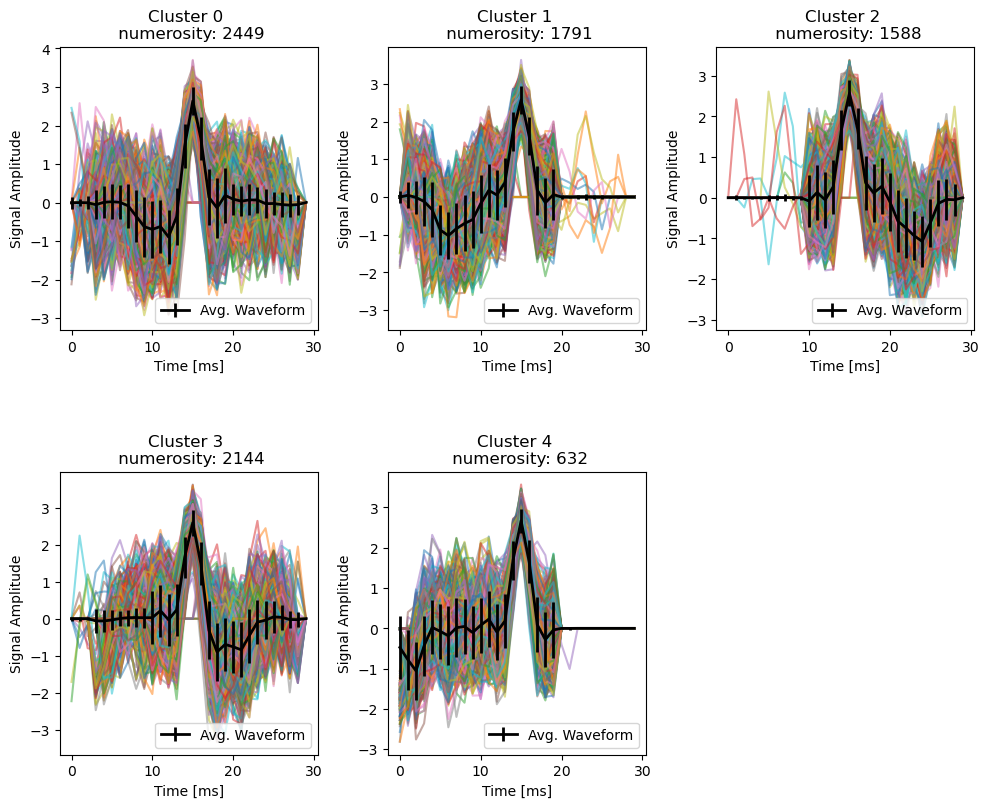

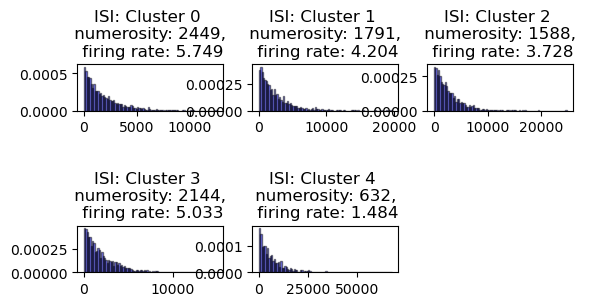

Total spikes:  7115
For 2 clusters, the silhouette score is: 0.108
For 3 clusters, the silhouette score is: 0.123
For 4 clusters, the silhouette score is: 0.126
For 5 clusters, the silhouette score is: 0.138
For 6 clusters, the silhouette score is: 0.140
For 7 clusters, the silhouette score is: 0.137
For 8 clusters, the silhouette score is: 0.140
For 9 clusters, the silhouette score is: 0.135
For 10 clusters, the silhouette score is: 0.138
For 11 clusters, the silhouette score is: 0.133
For 12 clusters, the silhouette score is: 0.128
For 13 clusters, the silhouette score is: 0.128
For 14 clusters, the silhouette score is: 0.131


Best cluster in the range 2 to  14 :  8 , with a silhouette score of:  0.1399073460779261   


firing rate threshold:  1.2418179304567216


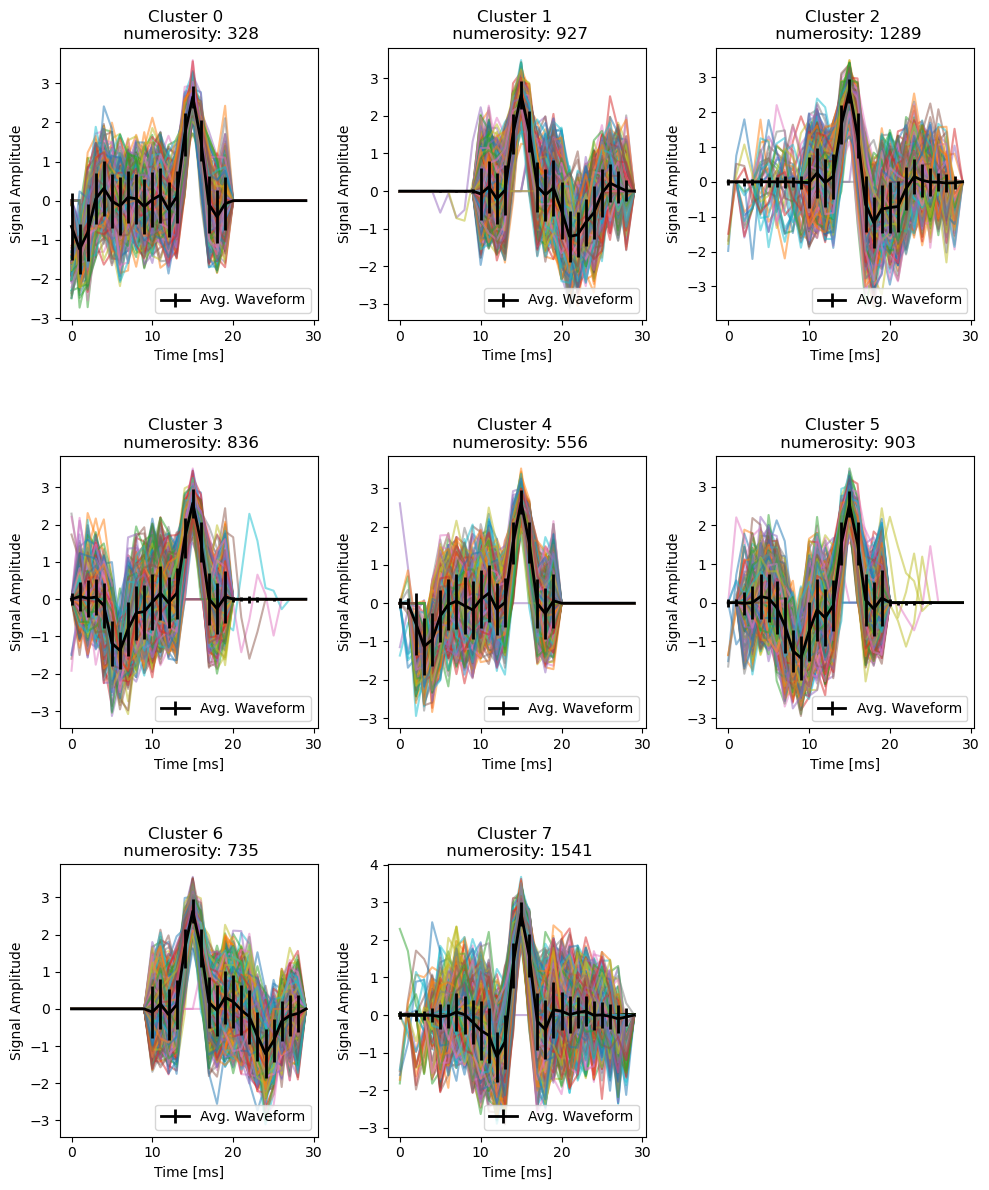

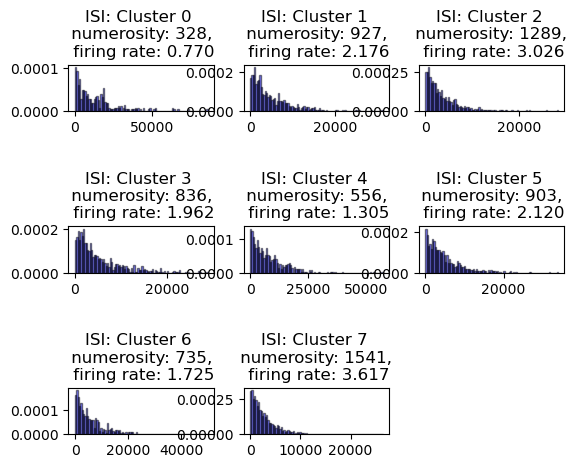

In [10]:
allinfo=[]
final_data_pos=[]
for channel in (tqdm(range(len(pos_cut)))):
    channel_clusters=clus(pos_cut[channel],'kmeans',n_pos[channel],prova.iloc[:,channel])
    final_data_pos.append(channel_clusters)
    allinfo.append(info)

In [ ]:
final_data_neg=[]
print(name_data)
for channel in (tqdm(range(len(neg_cut)))):
    channel_clusters=clus(neg_cut[channel],'kmeans',n_neg[channel],prova.iloc[:,channel])
    final_data_neg.append(channel_clusters)
    allinfo.append(info)

BL (less cut function) (window 3000, thresh4) fuzzy: (3.5, 3.5, 1.6) silhouette: 0.231    
BL (less cut function) (window 300) fuzzy: (17, 15, 6) silhouette: 0.215    
BL (more cut function) (window 300) fuzzy: (15, 16, 7) silhouette: 0.218    
BL (less cut function) fuzzy: (13, 13, 6) silhouette: 0.226    

KA (less cut function) (window 300, thresh4) fuzzy: (1.9, 1.12, 1.9) silhouette: 0.229   
KA (less cut function) (window 3000, thresh4) fuzzy: (1.4, 0.89, 1.4) silhouette: 0.223    
KA stimulation 3 clusters fuzzy: (3.9, 3.7, 2) silhouette: 0.214    
KA stimulation (more cut function) (window 3000) fuzzy: (2, 3.9, 3.7) silhouette: 0.214    
KA stimulation (more cut function) (window 300) fuzzy (4.5, 4.4, 2.2) silhouette: 0.204    
KA stimulation (more cut function) (window 300) dbscan (10.8,10.8)    

# Save

In [11]:
neurons = []
for electrode in final_data_pos:
    for neuron in electrode:
        neurons.append(neuron)
len(neurons)

41

In [14]:
len(neurons)
len(neurons[0])

683

In [ ]:
for neuron in final_data_neg:
    for neuron in electrode:
        neurons.append(neuron)
len(neurons)

In [24]:
print(len(neurons))#clusters
print(len(neurons[0]))#neuron indices for cluster

41
683


In [ ]:
adj_neur=[]
counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<=max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))
print(max_len)

In [ ]:
save_data = 'After'+name_data+'.txt'
print(name_data)

In [ ]:
#np.savetxt(save_data,adj_neur, delimiter=', ', fmt='%12.8f')
np.savetxt("/Users/Gaia_1/Desktop/tesi/Data after SS/%s.txt" % save_data,adj_neur, delimiter=', ', fmt='%12.8f')

In [ ]:
x=randint(0,len(adj_neur))
print('neur: ',x)
data_healthy=adj_neur[x]
ISI_healthy = np.diff(data_healthy)/10000

## Point Process

In [ ]:
#map_estimate = Bayesian_mixture_model(ISI_healthy)

#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)
    if 'Healthy' in net:
        print('target Healthy')
        map_estimate['Target']=0

    elif 'healthy' in net:
        print('target healthy')
        map_estimate['Target']=0

    elif 'health' in net:
        print('target health')
        map_estimate['Target']=0

    else:
        print('target pathological')
        map_estimate['Target']=1

    if 'KA' in net:
        map_estimate['Stimulation']=1

    elif 'stimulation' in net:
        map_estimate['Stimulation']=1
    else:
        map_estimate['Stimulation']=0

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset